In [ ]:
import numpy as np
import mujoco as mj

import mediapy as media
np.set_printoptions(precision=3, suppress=True)

In [2]:
def render(model, data=None, cam=-1, height=300, option=None):
  if data is None:
    data = mj.MjData(model)
  with mj.Renderer(model, 480, 640) as renderer:
    mj.mj_forward(model, data)
    renderer.update_scene(data, cam, scene_option=option)
    media.show_image(renderer.render(), height=height)

## Forward kinematics

FK 前向运动学就是将 `qpos` 映射到笛卡尔空间的位置 `xpos` 和姿态 `xmat`. 在 MuJoCo 里我们通过 `mj_forward(model, data)` 函数来得到 FK 的计算结果. 该函数需要两个参数:
- `model: MjModel` - 包含了所有**静态 (时间无关) 模型参数**, 一个良好建模的机械臂都会对 `joint` 添加取值范围, 我们可以通过 `model.jnt_range` 来访问
- `data: MjData` - 包含里所有**动态 (时间有关) 模型参数**, `data` 就是一个数据接口 (类似的例子还有 ROS 里的消息接口), 这里面的值需要在运动/动力学计算时用到, 计算完后里面的值会得到更新

假设在 MJCF 里已经定义了一个 `eef` site, 位于执行器末端. 教科书上所说的 FK 在这里就表示为 `(data.site_xpos, data.site_xmat) = FK(qpos)`. 类似的, 想要知道任何 kinematic tree 上某点的 FK, 只要提前定义好 body/geom/site, 都可以通过类似的方法得到.

In [3]:
def sample_qpos(model):
    range = model.jnt_range # [njnt x 2]
    return np.random.uniform(low=range[:,0], high=range[:,1], size=range.shape[0])

def sample_ctrl(model):
    range = model.actuator_ctrlrange # [nu x 2]
    return np.random.uniform(low=range[:,0], high=range[:,1], size=range.shape[0])

def print_xform(xform=None, xmat=None, xpos=None):
    if xform is not None:
        xmat = xform[:3,:3]
        xpos = xform[:3,-1]
    print('rotation:\n', xmat)
    print()
    print('position:\n', xpos)

In [4]:
a1_spec = mj.MjSpec.from_file('galaxea_a1/scene.xml')
a1_spec.visual.scale.framelength = 1
a1_spec.visual.scale.framewidth = 0.1

a1_spec.worldbody.add_site(name='world', size=[0.01,0.01,0.01]) # 加入 world site, 方便可视化

model = a1_spec.compile()

In [5]:
data = mj.MjData(model) # 从 model 初始化一个 data 数据接口

cam = mj.MjvCamera()
cam.azimuth = 90
cam.elevation =-45
cam.distance = 1.5
cam.lookat = [0,0,0.3]

voption = mj.MjvOption()
voption.label = mj.mjtLabel.mjLABEL_SITE
voption.frame = mj.mjtFrame.mjFRAME_SITE

rotation:
 [[-0.305 -0.307  0.902]
 [ 0.277  0.877  0.393]
 [-0.911  0.37  -0.182]]

position:
 [ 0.394 -0.097  0.637]


""

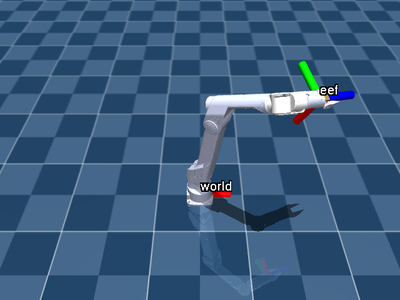

In [6]:
data.qpos[:] = sample_qpos(model) # 在 joint space 里随机采样
mj.mj_forward(model, data) # 笛卡尔空间里的物理量都要通过 FK(qpos) 来计算
eef_id = mj.mj_name2id(model, mj.mjtObj.mjOBJ_SITE, 'eef') # ✔当我们有多个 site 时, 通过 id 来访问
print_xform(xmat=data.site_xmat[eef_id].reshape(3,3), xpos=data.site_xpos[eef_id])

render(model, data, cam=cam, option=voption)

## D-H parameters

D-H 法实现 FK 的关键在于为每个构件**按照特定的规则**建立坐标系. D-H 存在多个版本 (`fmt`), 教科书上常介绍的有两种, `'standard'` 和 `'craig'`.

`DHTable` 实现了简单的 D-H 参数表, 表里的每一行代表一个坐标系变换, 例如 $T_{12}$ 可以理解为沿着 x 和 z-axis 的 screw 动作的相继作用 (顺序取决于 `fmt`), 把 frame1 搬运至 frame2.

In [7]:
from functools import partial

def _get_dh2mat_std(q, a, alpha, d, phi, type='r', degree=True):
    if type == 'r':
        phi += q
    elif type == 'p':
        d += q

    if degree:
        phi = np.deg2rad(phi)
        alpha = np.deg2rad(alpha)

    return np.array([
        [np.cos(phi), -np.sin(phi)*np.cos(alpha), np.sin(phi)*np.sin(alpha), a*np.cos(phi)],
        [np.sin(phi), np.cos(phi)*np.cos(alpha), -np.cos(phi)*np.sin(alpha), a*np.sin(phi)],
        [0, np.sin(alpha), np.cos(alpha), d],
        [0, 0, 0, 1]
    ])

def _get_dh2mat_craig(q, a, alpha, d, phi, type='r', degree=True):
    if type == 'r':
        phi += q
    elif type == 'p':
        d += q
    
    if degree:
        phi = np.deg2rad(phi)
        alpha = np.deg2rad(alpha)
    
    return np.array([
        [np.cos(phi), -np.sin(phi), 0, a],
        [np.sin(phi)*np.cos(alpha), np.cos(phi)*np.cos(alpha), -np.sin(alpha), -d*np.sin(alpha)],
        [np.sin(phi)*np.sin(alpha), np.cos(phi)*np.sin(alpha), np.cos(alpha), d*np.cos(alpha)],
        [0, 0, 0, 1]
    ])

def dh2mat(a, alpha, d, phi, type='r', fmt='standard', degree=True):
    if fmt == 'standard':
        return partial(_get_dh2mat_std, a=a, alpha=alpha, d=d, phi=phi, type=type, degree=degree)
    elif fmt == 'craig':
        return partial(_get_dh2mat_craig, a=a, alpha=alpha, d=d, phi=phi, type=type, degree=degree)
    else:
        raise ValueError(f'Unknown format: {fmt}')
 
def mat2dh(mat, fmt='standard', degree=True):
    if fmt == 'standard':
        a = mat[0,3] / mat[0,0] if mat[0,0] != 0 else mat[1,3] / mat[1,0]
        alpha = np.arctan2(mat[2,1], mat[2,2])
        d = mat[2,3]
        phi = np.arctan2(mat[1,0], mat[0,0])
    elif fmt == 'craig':
        a = mat[0,3]
        alpha = np.arctan2(-mat[1,2], mat[2,2])
        d = mat[1,3] / mat[1,2] if mat[1,2] != 0 else mat[2,3] / mat[2,2]
        phi = np.arctan2(-mat[0,1], mat[0,0])
    else:
        raise ValueError(f'Unknown format: {fmt}')
    
    if degree:
        phi = np.rad2deg(phi)
        alpha = np.rad2deg(alpha)
    return [a, alpha, d, phi]

In [8]:
class DHTable:
    def __init__(self, rows: list[list]=[], fmt='standard', degree=True):
        self.rows = rows
        self.mats = []
        self.nq = 0
        self.fmt = fmt
        self.degree = degree
        assert self.fmt in ['standard', 'craig']
        self.build()
    
    def build(self):
        if self.rows:
            for row in self.rows:
                assert len(row) == 5, 'Expect a row of 5: a, alpha, d, phi, type'
                assert row[-1] in ['r', 'p', 'f']
        self.mats.clear()
        self.nq = 0
        for row in self.rows:
            if row[-1] in ['r', 'p']: self.nq += 1
            self.mats.append(dh2mat(*row, fmt=self.fmt, degree=self.degree))
    
    def fk(self, qs):
        assert len(qs) == self.nq, f'Number mismatch, expect {self.nq} but got {len(qs)}'
        res = np.eye(4)
        ind = 0
        for i,row in enumerate(self.rows):
            if row[-1] in ['r', 'p']:
                res = res @ self.mats[i](qs[ind])
                ind += 1
            else:
                res = res @ self.mats[i](0)
        return res
    
    def __repr__(self):
        if self.fmt == 'standard':
            info = "Convention: standard DH"
            header = """
+---+----------+--------------+--------------+----------------+
| i |      a_i |      alpha_i |          d_i |          phi_i |
+---+----------+--------------+--------------+----------------+
"""     
        elif self.fmt == 'craig':
            info = "Convention: Craig's DH"
            header = """
+---+----------+--------------+--------------+----------------+
| i |  a_{i-1} |  alpha_{i-1} |          d_i |          phi_i |
+---+----------+--------------+--------------+----------------+
"""
        if self.degree:
            info += " (angle in degrees)"
        cxt = []
        for i in range(1, len(self.rows)+1):
            a,alpha,d,phi = [round(x, 3) for x in self.rows[i-1][:-1]]
            type = self.rows[i-1][-1]
            if type == 'r':
                cxt.append(f'| {i} | {a:<8} | {alpha:<12} | {d:<12} | q_{i} + {phi:<8} |')
            elif type == 'p':
                cxt.append(f'| {i} | {a:<8} | {alpha:<12} | q_{i} + {d:<6} | {phi:<14} |')
            else:
                cxt.append(f'| {i} | {a:<8} | {alpha:<12} | {d:<12} | {phi:<14} |')
        return info + header + '\n'.join(cxt) + '\n+---+----------+--------------+--------------+----------------+'

## Exercises

### PPP arm

PPP arm 的 workspace 是一立方体. 先在 MuJoCo 里建模, 为了和 D-H 对照, 这里在构建 body tree 时采用了 D-H 方法来确定 body frame (Craig's version). 

In [31]:
ppp_spec = mj.MjSpec()
ppp_spec.compiler.degree = True
ppp_spec.visual.scale.framewidth = 0.05

L = 0.5 # x/y/z half range
red = [0.8,0.2,0.2,1]
green = [0.2,0.8,0.2,1]
blue = [0.2,0.2,0.8,1]
yellow = [0.8,0.8,0.2,1]

base = ppp_spec.worldbody.add_body(name='base')
base.add_geom(name="base", type=mj.mjtGeom.mjGEOM_BOX, size=[0.05,0.05,L],
              euler=[-90,0,0], rgba=green)

link1 = base.add_body(name='link1', euler=[-90,0,-90])
link1.add_joint(name='q1', type=mj.mjtJoint.mjJNT_SLIDE, axis=[0,0,1], range=[-L,L]) # y-axis
link1.add_geom(type=mj.mjtGeom.mjGEOM_BOX, size=[0.1,0.1,0.06], rgba=green)
link1.add_geom(type=mj.mjtGeom.mjGEOM_BOX, size=[0.05,0.05,0.5],
               pos=[0,L,0], euler=[-90,0,0], rgba=red)

link2 = link1.add_body(name='link2', pos=[0,L,0], euler=[-90,0,90])
link2.add_joint(name='q2', type=mj.mjtJoint.mjJNT_SLIDE, axis=[0,0,1], range=[-L,L]) # x-axis
link2.add_geom(type=mj.mjtGeom.mjGEOM_BOX, size=[0.1,0.1,0.06], rgba=red)
link2.add_geom(type=mj.mjtGeom.mjGEOM_BOX, size=[0.05,0.05,L],
               pos=[0,-L,0], euler=[90,0,0], rgba=blue)

link3 = link2.add_body(name='link3', pos=[0,-L,0], euler=[90,0,0])
link3.add_joint(name='q3', type=mj.mjtJoint.mjJNT_SLIDE, axis=[0,0,1], range=[-L,L]) # z-axis
link3.add_geom(type=mj.mjtGeom.mjGEOM_BOX, size=[0.1,0.1,0.06], rgba=blue)

# eef
eef = link3.add_body(name='eef', pos=[0,0.2,0], euler=[-90,0,0])
eef.add_site(type=mj.mjtGeom.mjGEOM_BOX, size=[0.05,0.05,0.2], rgba=yellow)

# camera and light
ppp_spec.worldbody.add_camera(name='side', mode=mj.mjtCamLight.mjCAMLIGHT_TARGETBODY,
                              targetbody='eef', pos=[1,-2,1])
ppp_spec.worldbody.add_light(pos=[0,0,10], dir=[0,0,-1], directional=True)

In [32]:
model = ppp_spec.compile()
data = mj.MjData(model)

qpos: [-0.188  0.302 -0.193]


""

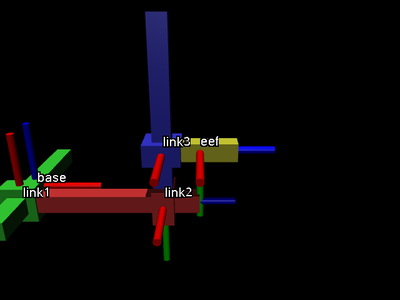

In [33]:
voption = mj.MjvOption()
voption.label = mj.mjtLabel.mjLABEL_BODY
voption.frame = mj.mjtFrame.mjFRAME_BODY
voption.flags[mj.mjtVisFlag.mjVIS_TRANSPARENT] = False

data.qpos = sample_qpos(model)
print('qpos:', data.qpos)
render(model, data, cam=0, option=voption)

In [12]:
ppp_dh = DHTable(
    [
        [0,-90,0,-90,'p'], # base to link1
        [0,-90,L,90,'p'],  # link1 to link2
        [0,90,L,0,'p'],    # link2 to link3
        [0,-90,0.2,0,'f']  # link3 to eef (fixed)
    ],
    fmt='craig',
    degree=True
)
ppp_dh

Convention: Craig's DH (angle in degrees)
+---+----------+--------------+--------------+----------------+
| i |  a_{i-1} |  alpha_{i-1} |          d_i |          phi_i |
+---+----------+--------------+--------------+----------------+
| 1 | 0        | -90          | q_1 + 0      | -90            |
| 2 | 0        | -90          | q_2 + 0.5    | 90             |
| 3 | 0        | 90           | q_3 + 0.5    | 0              |
| 4 | 0        | -90          | 0.2          | 0              |
+---+----------+--------------+--------------+----------------+

In [13]:
print_xform(ppp_dh.fk(data.qpos[:])) # last joint is fixed, len(qpos) == 3

rotation:
 [[ 0. -0.  1.]
 [-1.  0.  0.]
 [-0. -1. -0.]]

position:
 [0.458 0.094 0.224]


检查一下, D-H 得到的 (EE) FK 和 MuJoCo 给出的是一致的.

In [14]:
print_xform(xmat=data.site_xmat.reshape(3,3), xpos=data.site_xpos)

rotation:
 [[ 0.  0.  1.]
 [-1.  0.  0.]
 [ 0. -1.  0.]]

position:
 [[0.458 0.094 0.224]]


### Planar RR arm

经典的教科书例子. 平面 RR arm 的 workspace 是环形圆盘 (annular disk).

In [15]:
rr_spec = mj.MjSpec()
rr_spec.compiler.degree = True

L1 = 1
L2 = 1

base = rr_spec.worldbody.add_body(name='base')

link1 = base.add_body(name='link1')
link1.add_joint(name='q1', type=mj.mjtJoint.mjJNT_HINGE, axis=[0,0,1], range=[0,360])
link1.add_geom(type=mj.mjtGeom.mjGEOM_CAPSULE, size=[0.05,0,0], fromto=[0,0,0,L1,0,0])

link2 = link1.add_body(name='link2', pos=[1,0,0])
link2.add_joint(name='q2', type=mj.mjtJoint.mjJNT_HINGE, axis=[0,0,1], range=[0,360])
link2.add_geom(type=mj.mjtGeom.mjGEOM_CAPSULE, size=[0.05,0,0], fromto=[0,0,0,L2,0,0])

eef = link2.add_body(name='eef', pos=[L2,0,0])
eef.add_site(type=mj.mjtGeom.mjGEOM_SPHERE, size=[0.1,0,0], rgba=yellow)

# camera and light
rr_spec.worldbody.add_camera(name='top', mode=mj.mjtCamLight.mjCAMLIGHT_FIXED,
                             pos=[0,0,4], zaxis=[0,0,1])
rr_spec.worldbody.add_light(pos=[0,0,10], dir=[0,0,-1], directional=True)

In [16]:
model = rr_spec.compile()
data = mj.MjData(model)

qpos: [4.053 6.022]


""

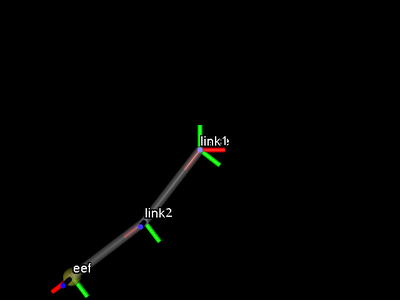

In [17]:
voption = mj.MjvOption()
voption.label = mj.mjtLabel.mjLABEL_BODY
voption.frame = mj.mjtFrame.mjFRAME_BODY
voption.flags[mj.mjtVisFlag.mjVIS_TRANSPARENT] = True

data.qpos = sample_qpos(model)
# 🚨注意到 MuJoCo 内部 (mjModel, mjData) 使用 radians, 即使在 MJCF 定义时用的是 degrees
print('qpos:', data.qpos)
render(model, data, cam=0, option=voption)

Standard D-H 建立坐标系在构件的末端, 所以 link2 的坐标系正好和 EEF 重合. 在 MuJoCo 里建模, 习惯默认 body frame 为 joint frame, 在 RR arm 这个例子里和 Craig's D-H 建立的坐标系一致 (一般来讲, 两者不同; MuJoCo 没有规定要如何标定坐标系).

In [18]:
rr_dh = DHTable(
    [
        [1, 0, 0, 0, 'r'],  # base to link1
        [1, 0, 0, 0, 'r']   # link1 to link2
    ],
    fmt='standard',
    degree=False
)
rr_dh

Convention: standard DH
+---+----------+--------------+--------------+----------------+
| i |      a_i |      alpha_i |          d_i |          phi_i |
+---+----------+--------------+--------------+----------------+
| 1 | 1        | 0            | 0            | q_1 + 0        |
| 2 | 1        | 0            | 0            | q_2 + 0        |
+---+----------+--------------+--------------+----------------+

In [19]:
print_xform(rr_dh.fk(data.qpos[:]))

rotation:
 [[-0.796  0.606  0.   ]
 [-0.606 -0.796  0.   ]
 [ 0.     0.     1.   ]]

position:
 [-1.408 -1.396  0.   ]


检查一下, D-H 得到的 (EE) FK 和 MuJoCo 给出的是一致的.

In [20]:
print_xform(xmat=data.site_xmat.reshape(3,3), xpos=data.site_xpos)

rotation:
 [[-0.796  0.606  0.   ]
 [-0.606 -0.796 -0.   ]
 [-0.     0.     1.   ]]

position:
 [[-1.408 -1.396  0.   ]]


### GalaXea A1

In [21]:
a1_spec = mj.MjSpec.from_file('galaxea_a1/scene.xml')
a1_spec.visual.scale.framelength = 1
a1_spec.visual.scale.framewidth = 0.05
a1_spec.visual.scale.jointwidth = 0.1
a1_spec.visual.rgba.joint = [0.8,0.8,0.2,1]

a1_spec.worldbody.add_site(name='world', size=[0.01,0.01,0.01]) # 加入 world site, 方便可视化

model = a1_spec.compile()

""

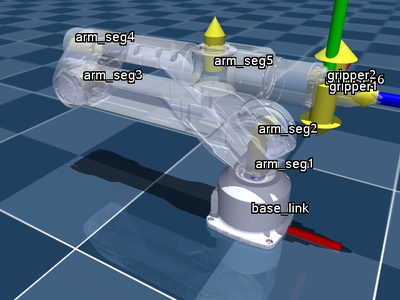

In [22]:
data = mj.MjData(model) # 从 model 初始化一个 data 数据接口

cam = mj.MjvCamera()
cam.azimuth = 120
cam.elevation =-30
cam.distance = .6
cam.lookat = [-0.1,0,0.1]

voption = mj.MjvOption()
voption.label = mj.mjtLabel.mjLABEL_BODY
voption.frame = mj.mjtFrame.mjFRAME_SITE
voption.flags[mj.mjtVisFlag.mjVIS_TRANSPARENT] = True
voption.flags[mj.mjtVisFlag.mjVIS_JOINT] = True

mj.mj_forward(model, data)

render(model, cam=cam, option=voption)

根据上面的侧视图和下面的信息 (origin of body frame, 全局坐标), 给出 A1 arm 的 D-H 参数.

In [23]:
for b,p in zip(a1_spec.bodies, data.xpos):
    print(b.name + ':', p)

print('eef:', data.site_xpos[1])

world: [0. 0. 0.]
base_link: [0. 0. 0.]
arm_seg1: [-0.001  0.     0.089]
arm_seg2: [-0.001  0.     0.151]
arm_seg3: [-0.35   0.     0.171]
arm_seg4: [-0.354 -0.     0.241]
arm_seg5: [-0.077 -0.     0.241]
arm_seg6: [0.081 0.    0.24 ]
gripper1: [0.084 0.014 0.229]
gripper2: [ 0.084 -0.014  0.252]
eef: [0.081 0.    0.24 ]


In [24]:
L = 0.35 - 0.001                     # seg2 到 seg3 的水平距离
H = 0.171 - 0.151                    # seg2 到 seg3 的垂直距离
phi2 = np.rad2deg(np.arctan2(H, L))  # seg2 到 seg3 的仰角
a2 = np.sqrt(H*H + L*L)              # seg2 到 seg3 的直线距离
a3 = 0.241 - 0.171                   # seg3 到 seg5 的垂直距离
d4 = 0.35 - 0.077                    # seg3 到 seg5 的水平距离
d7 = 0.081 + 0.077                   # seg5 到 eef 的水平距离

a1_dh = DHTable(
    [
        [-0.001,0,0.151,0,'r'],  # base to seg1
        [0,-90,0,-180+phi2,'r'], # seg1 to seg2
        [a2,0,0,90-phi2,'r'],    # seg2 to seg3
        [a3,-90,d4,-90,'r'],     # seg3 to seg4
        [0,-90,0,0,'r'],         # seg4 to seg5
        [0,90,0,0,'r'],          # seg5 to seg6
        [0,0,d7,0,'f']           # seg6 to eef (fixed)
    ],
    fmt='craig',
    degree=True
)
a1_dh

Convention: Craig's DH (angle in degrees)
+---+----------+--------------+--------------+----------------+
| i |  a_{i-1} |  alpha_{i-1} |          d_i |          phi_i |
+---+----------+--------------+--------------+----------------+
| 1 | -0.001   | 0            | 0.151        | q_1 + 0        |
| 2 | 0        | -90          | 0            | q_2 + -176.72  |
| 3 | 0.35     | 0            | 0            | q_3 + 86.72    |
| 4 | 0.07     | -90          | 0.273        | q_4 + -90      |
| 5 | 0        | -90          | 0            | q_5 + 0        |
| 6 | 0        | 90           | 0            | q_6 + 0        |
| 7 | 0        | 0            | 0.158        | 0              |
+---+----------+--------------+--------------+----------------+

检查 FK 的结果, 有一点小误差正常.

In [25]:
data.qpos = sample_ctrl(model)
mj.mj_forward(model, data)
print_xform(a1_dh.fk(np.rad2deg(data.qpos[:6])))

rotation:
 [[-0.328 -0.927  0.182]
 [ 0.796 -0.375 -0.476]
 [ 0.509 -0.011  0.861]]

position:
 [-0.248 -0.355  0.767]


In [26]:
print_xform(xmat=data.site_xmat[1].reshape(3,3), xpos=data.site_xpos[1])

rotation:
 [[-0.328 -0.927  0.182]
 [ 0.796 -0.375 -0.476]
 [ 0.509 -0.011  0.861]]

position:
 [-0.248 -0.355  0.767]
